# TalkingData AdTracking Fraud Detection Challenge

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

Link to the kaggle competition [https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection)

# Refrences

- [yuliagm](https://www.kaggle.com/yuliagm/talkingdata-eda-plus-time-patterns) Discovering time patterns, nice graphs, no models
- [tetyanayatsenko](https://www.kaggle.com/tetyanayatsenko/prepare-data-form-features-find-their-importance) Prepare data, form features, find features importance
- [antmarakis](https://www.kaggle.com/antmarakis/calculating-and-plotting-auc-score) Calculating and plotting AUC score
- [machinelearningmastery](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/) Avoid overfitting by early stopping with xgboost
- [trian2018](https://www.kaggle.com/trian2018/understand-competition-metric-auc-probabilities) Metric AUC probabilities
- [kimkartavyavimudh](https://github.com/kimkartavyavimudh/Kaggle-TalkingData/blob/master/Exploration%2Bon%2BFull%2BSet.ipynb) Exploration on Full Set
- [nanomathias](https://www.kaggle.com/nanomathias/feature-engineering-importance-testing) Feature Engineering importance testing
- [andymarsden100](https://www.kaggle.com/andymarsden100/getting-started) Getting started
- [swethaboga](https://www.kaggle.com/swethaboga/xgboost-approx-tree-method) XGBoost Approx Tree Method


- [curiousily](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd) Credit fraud with autoencoders

# Comments / Thoughs 

The IP addresses is encoded, because of data protection. Also looking at IP location is a bad idea because of the same IP doesn't mean it is from the same user. Especially if this is mobile operator. Most IP are shared, your phone most likely behind several (layered) NAT before its address exposed to internet.
[See here](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/51650)

But a user may be defined with a combination of IP, Device and OS

IP address did have a lot of nearness information. But we prefer kagglers to build a model without nearness information, because in China, IP address is highly unstable, user's IP can vary from time to time. [See more](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/51348)

# Working with big dataset on 16GB RAM

While working with largeee dataset as in this assignment with close to 200 millions data points we need to be smart with how me manage our data in the memory. While I have a MSI GS63VR laptop with i7-7700HQ, Nvidia GTX 1060 and 16GB RAM, that is a pretty high-end computer, 16GB RAM won't be enough to not overloading allocated RAM while working on the dataset.

After a couple hours on google and stackoverflow I came a cross [this notebook](https://www.kaggle.com/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask) that actually was published on the TalkingData AdTracking Fraud Detection Challenge that I'm working on in this assigment. The notebook contains 7 pro-tip on how to work on bigdata with limited resources.

- Tip 1 - Deleting unused variables and gc.collect()
- Tip 2 - Presetting the datatypes
- Tip 3 - Importing selected rows of a csv file
- Tip 4 - Importing in batches and processing each individually
- Tip 5 - Importing just selected columns
- Tip 6 - Creative data processing
- Tip 7 - Using Dask or Pandas on Ray

## Tip 1 - Deleting unused variables and gc.collect()

Python do have a nice garbage collector. But while working on huge dataset you can clean up the memory by deleting unused temporary variables.
For example if you have a variable `only_used_once` you can delete it by `del only_used_once`.
But even after deleting the variable there could be residual memory, so by using the garbage collector manually by importing it in the top of your project with `import gc`, you can call `gc.collect()` every time you want to free up some memory.

## Tip 2 - Presetting the datatypes

With pandas `read_csv` python will try to guess what datatype you are trying to load in to the memory. By defining the datatypes before importing, you can avoid that python is allocating more space than it needs to. Because Python will do that by default to avoid errors.
```python
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        }

train = pd.read_csv('train.csv', dtype=dtypes)
```

## Tip 3 - Importing selected rows of a csv file

Importing 200 millions rows at once will allocate almost all the memory on my computer, by selecting a specified number of rows to import we can avoid that. Then we can do our analyse and look at the data before we go on to analyse the whole dataset.
```python
X_train = pd.read_csv('train.csv', nrows=10000)
```
We can also skip rows, the reason we may do that is to look at other ranges in the dataset. By specifing `skiprows=range(1, 500000)` we can skip the first 500 000 rows in the data set. and by using range we still can keep the first row as our headings.

By using the `skiprows` we can also generate our own random sampling. 

```python
#generate list of lines to skip
skiplines = np.random.choice(np.arange(1, lines), size=lines-1-1000000, replace=False)

#sort the list
skiplines=np.sort(skiplines)

# Import the randomly selected 1 million rows
train = pd.read_csv('../input/train.csv', skiprows=skiplines, dtype=dtypes)

# Delete useless `skipline` list and free up memory
del skiplines
gc.collect()
```

## Tip 4 - Importing on batches and processing each individually

When we want to analyse or do some processing on the whole dataset we can't get it into the memory without over allocation the memory. A solution to that is to do the work in batches. We use chunk's of data, that we specify the size of. We then do some work on each chunk util there are no more chunk's left. Then we have worked over the whole dataset.

The example under is for analyzing the `is_attributed` attribute. We loop through the dataset chunk by chunk and then we can filter out the clicks that was attributed (`is_attributed==1` => the app was downloaded) into a separate dataframe for futher inspection.

```python
#set up an empty dataframe
df_converted = pd.DataFrame()

#we are going to work with chunks of size 1 million rows
chunksize = 10 ** 6

#in each chunk, filter for values that have 'is_attributed'==1, and merge these values into one dataframe
for chunk in pd.read_csv('train.csv', chunksize=chunksize, dtype=dtypes):
    filtered = (chunk[(np.where(chunk['is_attributed']==1, True, False))])
    df_converted = pd.concat([df_converted, filtered], ignore_index=True, )

```

We can then run `df_converted.info()` to see that there is `x` entries for when the app was downloaded.


## Tip 5 - Importing just selected columns

Importing just two fields instead of the whole table is a much better approach for optimalizating the memory allocation. By using the `usecols` in `read_csv` we can achieve that.

```python
#wanted columns
columns = ['ip', 'click_time', 'is_attributed']
dtypes = {
        'ip'            : 'uint32',
        'is_attributed' : 'uint8',
        }

ips_df = pd.read_csv('train.csv', usecols=columns, dtype=dtypes)
```

## Tip 6 - Creative data processing

The kernel cannot handle groupby on the whole dataframe, But it can do it in sections. So we can calculate counts in batches, merge them and sum up to total counts.

```python
size=100000
all_rows = len(ips_df)
num_parts = all_rows//size

#generate the first batch
ip_counts = ips_df[0:size][['ip', 'is_attributed']].groupby('ip', as_index=False).count()

#add remaining batches
for p in range(1,num_parts):
    start = p*size
    end = p*size + size
    if end < all_rows:
        group = ips_df[start:end][['ip', 'is_attributed']].groupby('ip', as_index=False).count()
    else:
        group = ips_df[start:][['ip', 'is_attributed']].groupby('ip', as_index=False).count()
    ip_counts = ip_counts.merge(group, on='ip', how='outer')
    ip_counts.columns = ['ip', 'count1','count2']
    ip_counts['counts'] = np.nansum((ip_counts['count1'], ip_counts['count2']), axis = 0)
    ip_counts.drop(columns=['count1', 'count2'], axis = 0, inplace=True)
```


## Tip 7 - Using Dask or Pandas on Ray

With Dask you will need to change the code. But with Ray you can use it as normal Pandas.
- [Dask - Dataframe](http://docs.dask.org/en/latest/dataframe.html)
- [Modin - Dataframe](https://github.com/modin-project/modin)

Example with Padas on Ray:
```python
#import pandas as pd
import modin.pandas as pd
train = pd.read_csv(train.csv)
```

# Setup

In [1]:
# To suppress some warnings below. Nothing important, just to make some outputs cleaner.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

In [3]:
import gc
import subprocess
import os.path
import shutil
import zipfile

import matplotlib
import sklearn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from collections import Counter

In [4]:
import pandas as pd

# Using modin for parallell pandas
# import modin.pandas as pd

In [5]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

# Get the data

To get the data we can use several methods. I'm going to use the Kaggle API to download the datasets from the competition.

After I have downloaded the datasets, they are in zip archives, so I need to extract the files using the ZipFile library.

The kaggle API is checking it the files is already dowloaded and will only re-download the files if they are outdated.

Then I made a simple function to check if the train.csv is already present, if not then I need to extract it from the archive.

In [6]:
import kaggle

!kaggle competitions download -c talkingdata-adtracking-fraud-detection -p datasets

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_sample.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_supplement.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
def get_train_csv():
    # Check if train.csv allready exists
    if os.path.isfile("datasets/train.csv"):
        print("Train.csv already exists skipping..")
    else:
        # Check if train.csv.zip exists, then unzip and move the content to datasets folder
        print("Train.csv does not exists in datasets")
        if os.path.isfile("datasets/train.csv.zip"):
            print("Extracting train.csv.zip...")
            with zipfile.ZipFile("datasets/train.csv.zip","r") as zip_ref:
                zip_ref.extractall("datasets")

            print("Moving train.csv to datasets/train.csv")
            os.rename("datasets/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv", "datasets/train.csv")
            shutil.rmtree('datasets/mnt', ignore_errors=True)
            print("Done")

def get_test_csv():
    if os.path.isfile("datasets/test.csv"):
        print("Test.csv already exists skipping...")
    else:
        if os.path.isfile("datasets/test.csv.zip"):
            print("Extracting test.csv.zip...")
            with zipfile.ZipFile("datasets/test.csv.zip", "r") as zip_ref:
                zip_ref.extractall("datasets")
            print("Done")


In [8]:
%%time
get_train_csv()
get_test_csv()

Train.csv already exists skipping..
Test.csv already exists skipping...
CPU times: user 24 µs, sys: 565 µs, total: 589 µs
Wall time: 428 µs


Before we import the data we need to define the labels of the train data and the test data.
The test data is missing one column, the `is_attributed`.

We also need to define the datatypes of each attribute to optimize the memory usage, as previously mentioned.

In [9]:
train_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_cols  = ['ip', 'app', 'device', 'os', 'channel', 'click_time']

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

# train = pd.read_csv('datasets/train.csv', skiprows=range(1,5000000),nrows=1000000, dtype=dtypes, header=0)
# train = pd.read_csv('datasets/train.csv', dtype=dtypes, header=0)

## A temporary random sample

Because of the large dataset, I can't load the whole train dataset into the memory of my computer and then do calculations.

So I want to create a random sample such that we can analyse if the data is organized by click time. So a random sample should roughly span the full time period and mimick the click pattern.

Counting the lines in the original dataset I borrowed [Olafur's answer](https://stackoverflow.com/questions/845058/how-to-get-line-count-cheaply-in-python) from stackoverflow.

Checking if a file exists, [PierreBdR's answer](https://stackoverflow.com/questions/82831/how-do-i-check-whether-a-file-exists-in-python).

Writing dataframe to csv, [Andy Hayden's answer](https://stackoverflow.com/questions/16923281/pandas-writing-dataframe-to-csv-file)

So in the `get_rand_csv` I'm creating a random list of rows to skip data, and then read the train dataset csv file while both skipping the selected rows from the random list, and also specify the datatype.

Then I write the randomly generated dataframe to a csv file for later use. 

And the method is also checking whether the `random_train.csv` file exists or not, so that we are not generating the csv file unnecessary because it takes some time to generate.

And underway I'm running the garbage collector to free up variables we don't need anymore.

In [10]:
def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, 
                                              stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0])

def get_rand_csv(org_fname = 'datasets/train.csv', rnd_fname = 'datasets/random_train.csv', nrows = 1000000):
    if os.path.exists(rnd_fname):
        return pd.read_csv(rnd_fname, dtype=dtypes)
    
    lines = file_len(org_fname)
    print('Number of lines in', org_fname, 'is:', lines)

    #generate list of lines to skip
    skiplines = np.random.choice(np.arange(1, lines), size=lines-1-nrows, replace=False)

    del lines
    gc.collect()

    #sort the list
    skiplines=np.sort(skiplines)

    data = pd.read_csv(org_fname, skiprows=skiplines, dtype=dtypes)
    data.to_csv(rnd_fname, encoding='utf-8', index=False)
    
    del skiplines
    gc.collect()
    
    return data

In [11]:
%%time
train = get_rand_csv(nrows=1000000)

CPU times: user 760 ms, sys: 34.6 ms, total: 795 ms
Wall time: 798 ms


## The shape and the head of the random generated data

In [12]:
train.shape

(1000000, 8)

In [13]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,84774,3,1,19,379,2017-11-06 15:47:52,NaN,0
1,109938,9,1,13,442,2017-11-06 16:00:00,NaN,0
2,44663,2,1,22,477,2017-11-06 16:00:00,NaN,0
3,182113,11,1,19,319,2017-11-06 16:00:00,NaN,0
4,109393,20,1,32,259,2017-11-06 16:00:01,NaN,0


# Exploring the data

In this section we will explore and look at the different aspects of the data.
We will also optimize the datatype of the different fields to save some memory on the computer.

## Data Fields

Each row of the training data contains a click record, with the following features.

- `ip`: ip address of click.
- `app`: app id for marketing.
- `device`: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- `os`: os version id of user mobile phone
- `channel`: channel id of mobile ad publisher
- `click_time`: timestamp of click (UTC)
- `attributed_time`: if user download the app for after clicking an ad, this is the time of the app download
- `is_attributed`: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

- `click_id`: reference for making predictions
- `is_attributed`: not included

## Creating Features

### Extracting time information

To gain some more information from the `click_time` feature we can extract hour, minute, second, day, week day, day of the year and week number.

We can also convert the `click_time` and `attributed_time` to timeseries type such that we can make calculations on those fields.

I also specify the type of the extracted new features to optimize memory usage.

In [14]:
def preprocessClicktime(df):
    df['click_time']      = pd.to_datetime(df['click_time'])
    df['hour']   = df['click_time'].dt.hour.astype('uint8')
    df['minute'] = df['click_time'].dt.minute.astype('uint8')
    df['second'] = df['click_time'].dt.second.astype('uint8')
    df['day']    = df['click_time'].dt.day.astype('uint8')
    df['dow']    = df['click_time'].dt.dayofweek.astype('uint8')
    df["doy"]    = df['click_time'].dt.dayofyear.astype('uint8')
    df['woy']    = df['click_time'].dt.week.astype('uint8')
    return df

train = preprocessClicktime(train)
train['attributed_time'] = pd.to_datetime(train['attributed_time'])

print(train.dtypes) 

ip                         uint32
app                        uint16
device                     uint16
os                         uint16
channel                    uint16
click_time         datetime64[ns]
attributed_time    datetime64[ns]
is_attributed               uint8
hour                        uint8
minute                      uint8
second                      uint8
day                         uint8
dow                         uint8
doy                         uint8
woy                         uint8
dtype: object


In [15]:
train.describe(include='all')

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,minute,second,day,dow,doy,woy
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000,2516,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0
unique,NaN,NaN,NaN,NaN,NaN,234278,2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,2017-11-09 01:11:24,2017-11-07 13:58:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2017-11-06 15:47:52,2017-11-06 16:03:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-11-09 16:00:00,2017-11-09 15:58:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,90973.555229,12.008897,21.769487,22.715041,268.686408,NaN,NaN,0.002516,9.288628,29.346209,29.577688,7.863239,1.863239,55.863239,45.0
std,69628.509993,14.811928,259.662478,55.482650,129.606829,NaN,NaN,0.050097,6.168051,17.376922,17.239847,0.889851,0.889851,0.889851,0.0
min,6.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,54.000000,45.0
25%,40245.000000,3.000000,1.000000,13.000000,145.000000,NaN,NaN,0.000000,4.000000,14.000000,15.000000,7.000000,1.000000,55.000000,45.0


## Plotting the data

In [16]:
frequent_hour = train.hour.value_counts().sort_index()
frequent_day = train.day.value_counts().sort_index()
frequent_doy = train.doy.value_counts().sort_index()
frequent_dow = train.dow.value_counts().sort_index()
frequent_minute = train.minute.value_counts().sort_index()
frequent_second = train.second.value_counts().sort_index()

### Frequency subplots

Here is some frequency bar plots of frequent hours, frequent days, frequent day of year, frequent day of week, frequent minutes and frequent seconds. Later we will look more at the frequent hour plot.

262

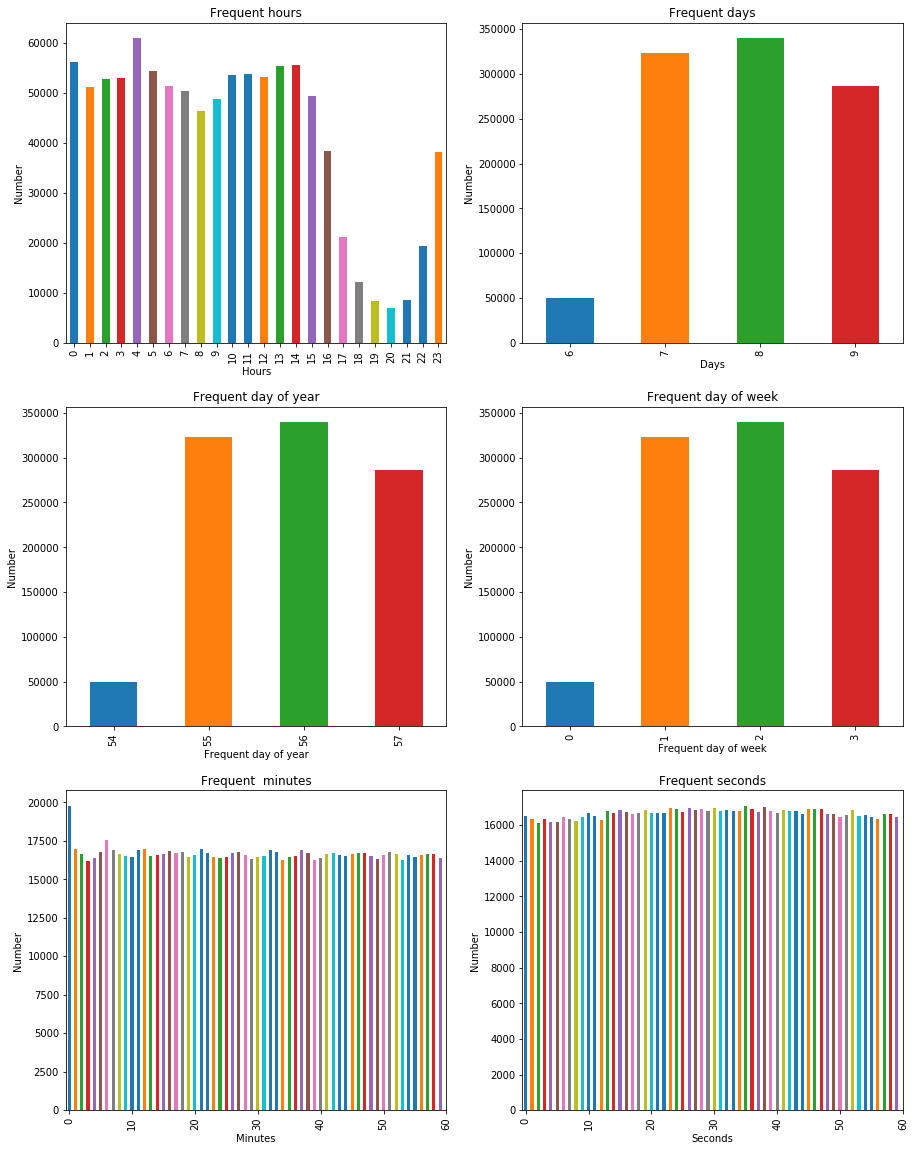

In [17]:
plt.figure(figsize=(15,20))
plt.subplot(321)
frequent_hour.plot(kind='bar')
plt.title("Frequent hours")
plt.xlabel("Hours")
plt.ylabel("Number")

plt.subplot(322)
frequent_day.plot(kind='bar')
plt.title("Frequent days")
plt.xlabel("Days")
plt.ylabel("Number")

plt.subplot(323)
frequent_doy.plot(kind='bar')
plt.title("Frequent day of year")
plt.xlabel("Frequent day of year")
plt.ylabel("Number")

plt.subplot(324)
frequent_dow.plot(kind='bar')
plt.title("Frequent day of week")
plt.xlabel("Frequent day of week")
plt.ylabel("Number")

plt.subplot(325)
frequent_minute.plot(kind='bar')
plt.xticks(np.arange(0, 69, step=10), (0,10,20,30,40,50,60))
plt.title("Frequent  minutes")
plt.xlabel("Minutes")
plt.ylabel("Number")

plt.subplot(326)
frequent_second.plot(kind='bar')
plt.xticks(np.arange(0, 69, step=10), (0,10,20,30,40,50,60))
plt.title("Frequent seconds")
plt.xlabel("Seconds")
plt.ylabel("Number")

# Free up memory and call garbage collector
del frequent_hour,frequent_day,frequent_doy,frequent_dow,frequent_minute,frequent_second
gc.collect()

### Frequency histogram subplots

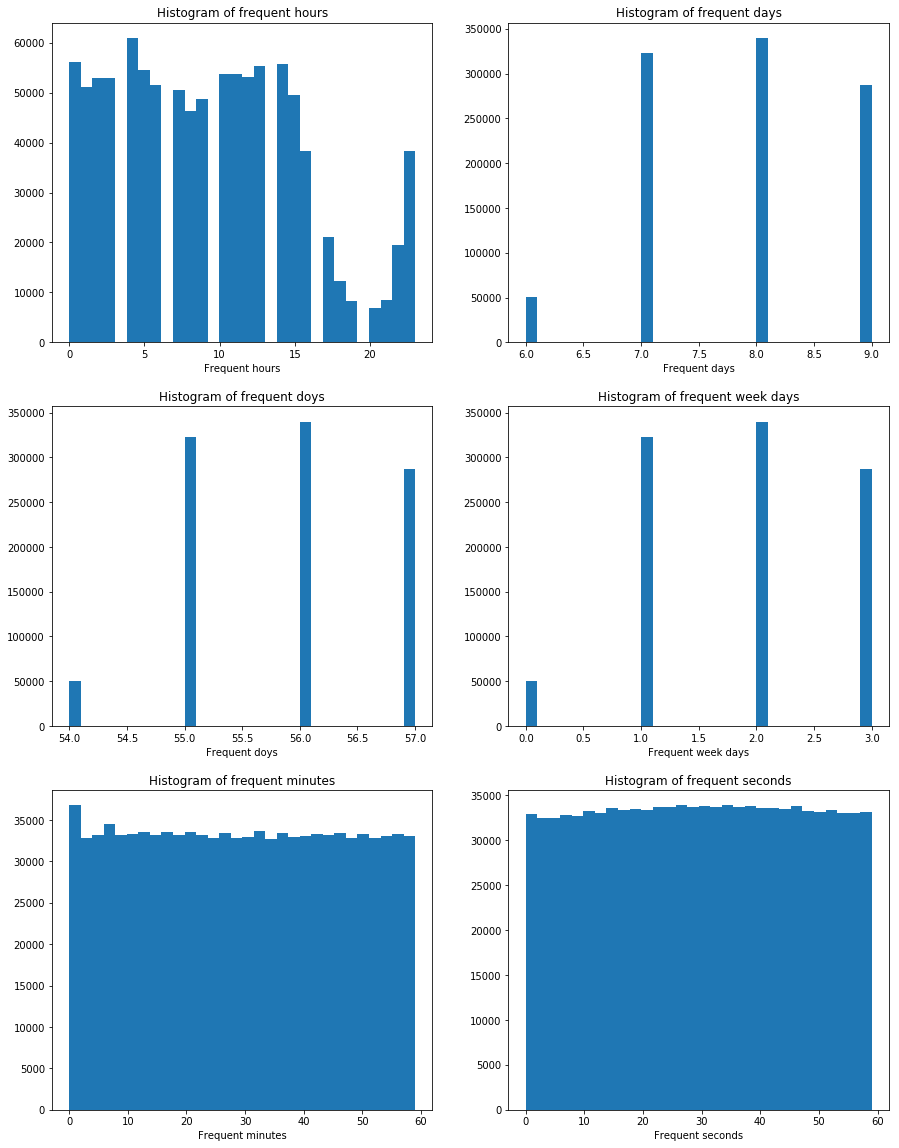

In [18]:
BIN = 30
plt.figure(figsize=(15,20))
plt.subplot(321)
plt.hist(train['hour'], bins=BIN)
plt.title("Histogram of frequent hours")
plt.xlabel("Frequent hours")

plt.subplot(322)
plt.hist(train['day'], bins=BIN)
plt.title("Histogram of frequent days")
plt.xlabel("Frequent days")

plt.subplot(323)
plt.hist(train['doy'], bins=BIN)
plt.title("Histogram of frequent doys")
plt.xlabel("Frequent doys")

plt.subplot(324)
plt.hist(train['dow'], bins=BIN)
plt.title("Histogram of frequent week days")
plt.xlabel("Frequent week days")

plt.subplot(325)
plt.hist(train['minute'], bins=BIN)
plt.title("Histogram of frequent minutes")
plt.xlabel("Frequent minutes")

plt.subplot(326)
plt.hist(train['second'], bins=BIN)
plt.title("Histogram of frequent seconds")
plt.xlabel("Frequent seconds")
plt.show()

### Hourly click frequency over time

When we look at the hourly click frequency over time, by rounding the `click_time` to nearest hour we can view some time pattern in the click frequency.

But there is no clear hourly time pattern in ratios, however there is a definete pattern in frequency of clicks based on time of day.

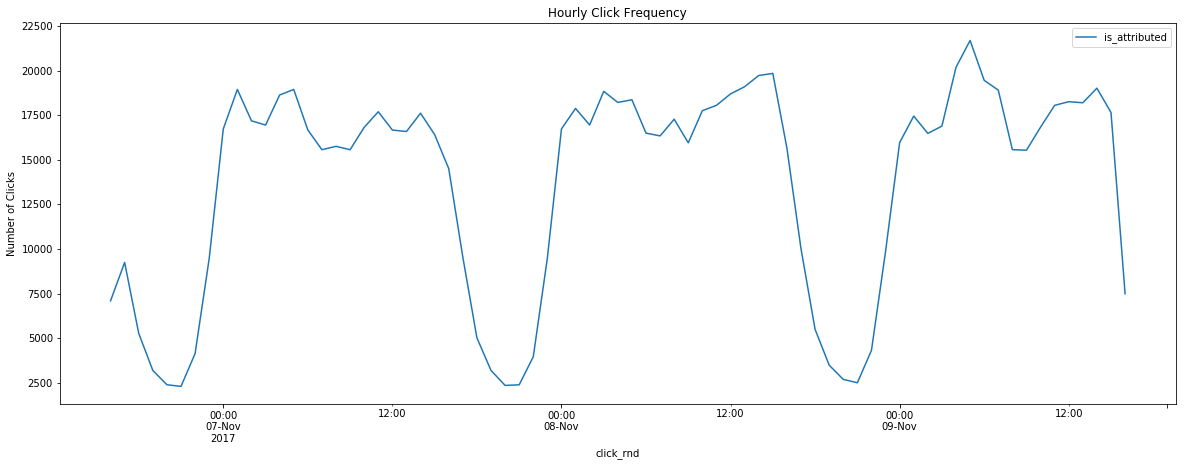

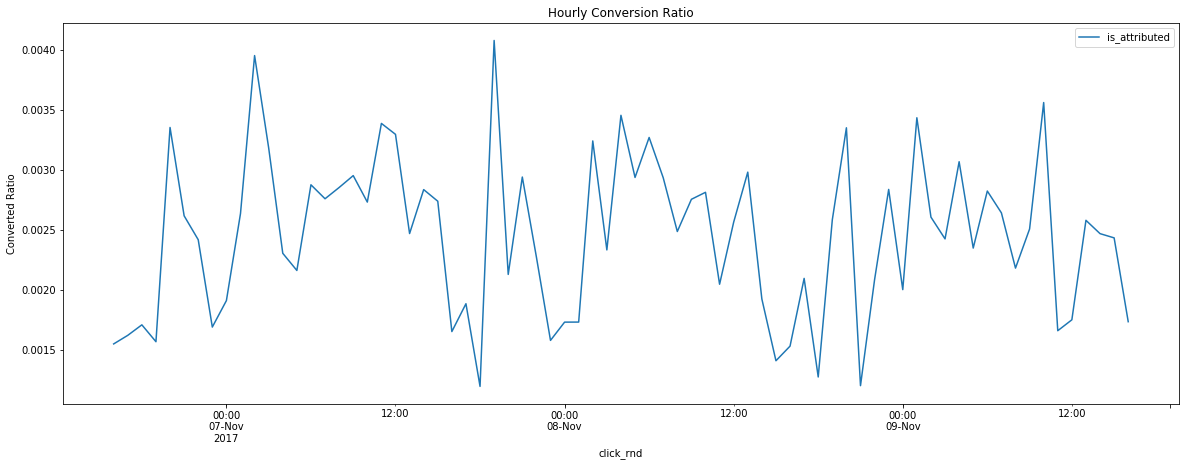

In [19]:
#round the time to nearest hour
train['click_rnd']=train['click_time'].dt.round('H')  

#check for hourly patterns
train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot(figsize=(20, 7))
plt.title('Hourly Click Frequency');
plt.ylabel('Number of Clicks');

train[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot(figsize=(20, 7))
plt.title('Hourly Conversion Ratio');
plt.ylabel('Converted Ratio');

### Hourly click frequency grouped by click hour

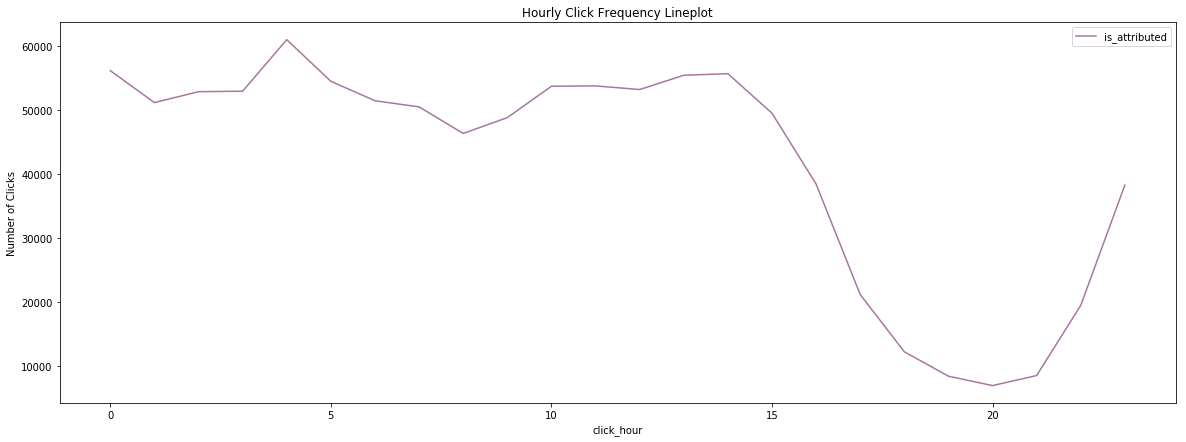

In [20]:
train['click_hour']=train['click_time'].dt.hour

train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1', figsize=(20, 7))
plt.title('Hourly Click Frequency Lineplot');
plt.ylabel('Number of Clicks');

### Hourly conversion ratio grouped by click hour

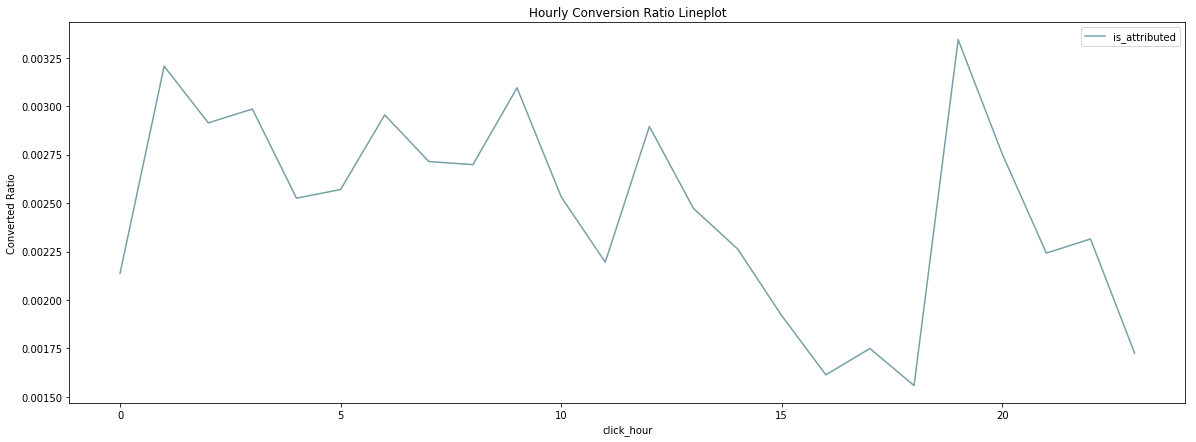

In [21]:
train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(color='#75a1a6', figsize=(20, 7))
plt.title('Hourly Conversion Ratio Lineplot');
plt.ylabel('Converted Ratio');

### Click count vs Proportion converted 

57065

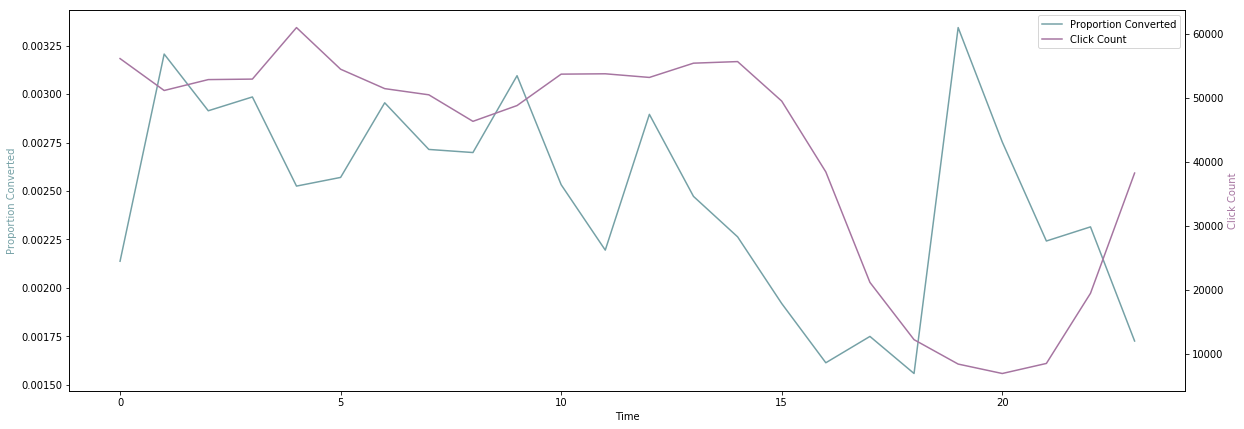

In [22]:
#adapted from https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales
#smonek's answer


group = train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure(figsize=(20, 7))
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

train = train.drop(['click_hour'], axis=1)

del group, x, ymean, ycount
gc.collect()

## Calculating time passed

We can calculate the time passed between clicking on the ad and when starting to download the app by substracting the `attributed_time` by `click_time`. 

We can then print out the five first rows where the app actually was downloaded.

In [23]:
train['time_pass']= train['attributed_time']-train['click_time']
#check:
train[train['is_attributed']==1][:5]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,minute,second,day,dow,doy,woy,click_rnd,time_pass
358,141422,72,1,19,101,2017-11-06 16:01:11,2017-11-06 16:15:12,1,16,1,11,6,0,54,45,2017-11-06 16:00:00,00:14:01
471,208340,29,1,19,333,2017-11-06 16:01:33,2017-11-06 16:03:20,1,16,1,33,6,0,54,45,2017-11-06 16:00:00,00:01:47
616,61970,18,1,13,107,2017-11-06 16:02:08,2017-11-06 16:55:11,1,16,2,8,6,0,54,45,2017-11-06 16:00:00,00:53:03
1240,172310,19,0,24,213,2017-11-06 16:04:30,2017-11-07 08:16:17,1,16,4,30,6,0,54,45,2017-11-06 16:00:00,16:11:47
2022,58741,35,1,19,274,2017-11-06 16:07:27,2017-11-06 16:18:51,1,16,7,27,6,0,54,45,2017-11-06 16:00:00,00:11:24


We can then look at the `describe` function of the column `time_pass`.

Some interesting numbers to look at could be the `min` output, there is very little chance that a normal user could be clicking on an ad and then downloading the app by 1 second.

In [24]:
train['time_pass'].describe()

count                      2516
mean     0 days 01:22:55.994833
std      0 days 02:46:00.095347
min             0 days 00:00:01
25%             0 days 00:00:54
50%      0 days 00:04:40.500000
75%      0 days 01:15:09.500000
max             0 days 20:37:25
Name: time_pass, dtype: object

## Correlation matrix and heatmap 

In [25]:
corr_matrix = train.corr()
corr_matrix['is_attributed'].sort_values(ascending = False)

is_attributed    1.000000
app              0.057392
ip               0.052651
os               0.004301
device           0.001445
minute           0.000860
doy              0.000540
dow              0.000540
day              0.000540
second          -0.000974
hour            -0.005243
channel         -0.023808
woy                   NaN
Name: is_attributed, dtype: float64

In [26]:
from pandas.plotting import scatter_matrix
# scatter_matrix(train[['ip', 'app', 'os', 'device', 'channel']], figsize=(20, 20), alpha=0.3)

We can see that there is a strong correlation between OS and Device. It makes sense when you think about what devices we usually use to browse, an iPhone will alway run iOS and Android devices will run Android. Computers will usually run Windows or Linux, and Mac's will run MacOS.

Also there is a strong correlation between the device and the app.

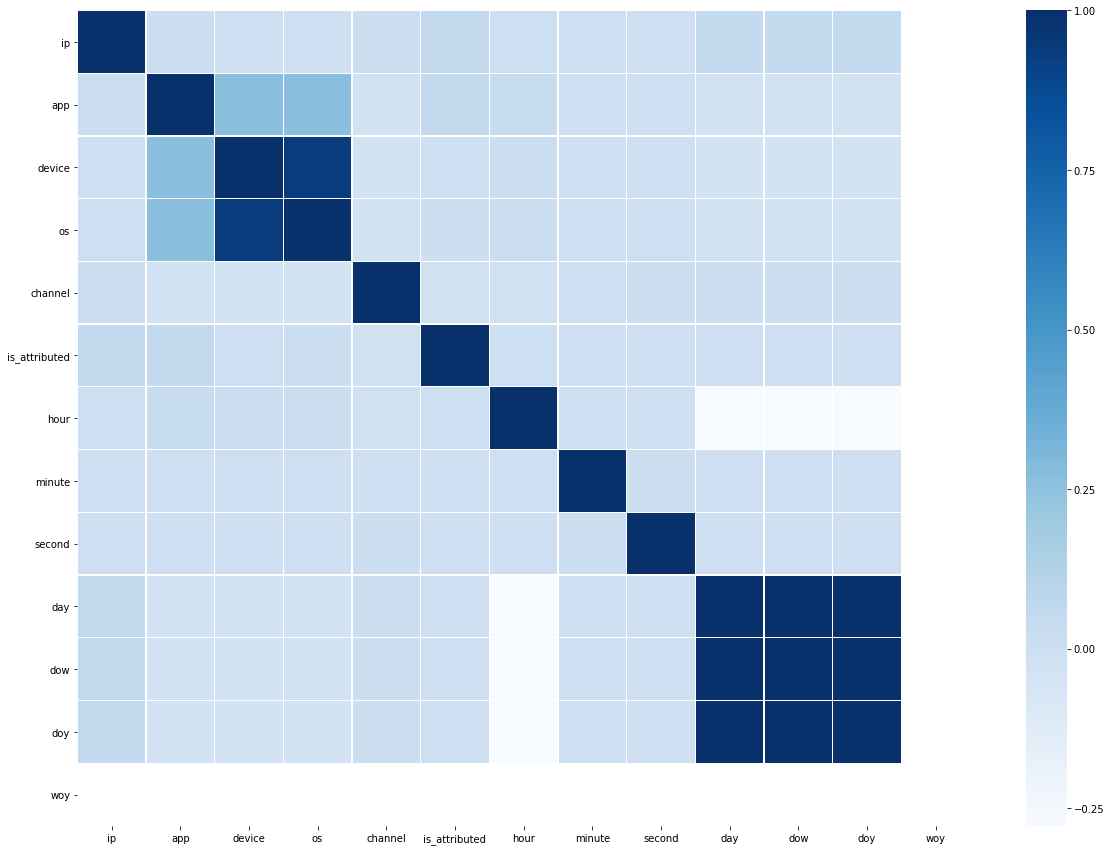

In [27]:
import seaborn as sns

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='Blues', linewidths=0.3)
plt.show()

# Training

## Using XGBoost with GPU

Tree construction (training) and prediction can be accelerated with CUDA-capable GPUs.

In XGBoost we decide with the `three_method` parameter what algorithm we want to use for the tree construction algorithm. We have two algorithm's to choose from `gpu_exact` and `gp_hist`.

`gpu_exact`	is the standard XGBoost tree construction algorithm. It performs exact search for splits. But it's slower and uses considerably more memory than `gpu_hist`.

`gpu_hist` is equivalent to the XGBoost fast histogram algorithm. It's much faster and uses considerably less memory than `gpu_exact`. But a very important note is that it will run very slowly on GPUs older than Pascal architecture. In my laptop I have a Nvidia GeForce 1060 6GB, and therefore use the `gpu_hist`algorithm in the models.

## Initiate the submition dataframe

To follow the Kaggle rules, they require a submittion csv file. The submittion csv file should contains two columns. The `click_id` as column 0, and a propability for `is_attributed` as column 1 that gives the probability for each `click_id` is attributed.

So I'm creating a `sub` dataframe that copies the `click_id` column from the test set. And will later after the training of the models predict the `is_attributed` column. 

In [28]:
import xgboost as xgb

train = train.drop(['click_time','click_rnd', 'time_pass', 'attributed_time'], axis=1)

y = train['is_attributed']
train = train.drop(['is_attributed'], axis=1)

In [29]:
def plotROC(a, b):
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(a, b)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(20, 7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [30]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

def plotRecallCurve(ytest, pred, proba):
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(ytest, proba)
    # calculate F1 score
    f1 = f1_score(ytest, pred)
    # calculate precision-recall AUC
    aucc = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(ytest, proba)
    print('f1=%.3f auc=%.3f ap=%.3f' % (f1, aucc, ap))
    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.')
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    # show the plot
    plt.show()
    plot_precision_recall_vs_threshold(precision, recall, thresholds)
    plt.show()
    
def subRecallCurve(ytest, pred, proba, label):
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(ytest, proba)
    # calculate F1 score
    f1 = f1_score(ytest, pred)
    # calculate precision-recall AUC
    aucc = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(ytest, proba)
    print('f1=%.3f auc=%.3f ap=%.3f' % (f1, aucc, ap))
    # plot the roc curve for the model
    return plt.plot(recall, precision, marker='.', label=label)

In [31]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

def printScoring(y, pred):
    score = average_precision_score(y, pred)
    print('Area under the precision-recall curve: {:.6f}'.format(score))

    predictions_round=pred.round()
    score = precision_score(y, predictions_round)
    print('Precision score: {:.6f}'.format(score))

    score = recall_score(y, predictions_round)
    print('Recall score: {:.6f}'.format(score))

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import itertools

def plot_confusion_matrix(cm, classes, ax=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, labels=True):
    """
    This function prints and plots the confusion matrix.
    From 
    """
    
    if not ax: fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.setp(ax, xticks=tick_marks, xticklabels=classes, 
             yticks=tick_marks, yticklabels=classes,
             title=title, xlabel="Predicted label", 
             ylabel="True label")
    #ax.set_xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if labels:
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(int(cm[i, j]), fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    return ax

## XGBoost standard params grid

XGBoost standard param grid

In [33]:
xgb_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.0, 1.0, 1.5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 6, 7, 8, 10]
    }


xgb_param_grid_large = {
        'learning_rate': [0.1, 0.05, 0.2],
        'n_estimators': [50, 100, 500, 600],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.0, 1.0, 1.5],
        'subsample': [0.6, 1.0],
        'colsample_bytree': [0.5, 0.6, 0.8],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'reg_lambda': [1, ]
    }

## Make a copy of the train set and drop null values

In [34]:
# Make a copy
train_copy = train.copy()

# Drop null values
#train.dropna()
print()

## Creating the train test split set

Creating a train and test dataset with the `train_test_split` method, splitting 20% of the data as the test-set

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train, y, stratify=y, test_size=0.2, random_state=42)

In [36]:
# from sklearn.preprocessing import OneHotEncoder

# categories = ['app', 'device', 'os']

# encoder = OneHotEncoder()

# for cat in categories:
#     train_cat = train[cat]
#     train_cat_reshaped = train_cat.values.reshape(-1,1)
#     train_cat_1hot = encoder.fit_transform(train_cat_reshaped)
#     arr = train_cat_1hot.toarray()
#     print(arr)
#     train[cat] = arr
#     print(train[cat].head(10))
#     del train_cat, train_cat_1hot, train_cat_reshaped
#     gc.collect()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attribs = ['ip', 'channel', 'hour', 'minute', 'second', 'day', 'dow', 'doy', 'woy']
cat_attribs = ['app', 'device', 'os']

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median"))
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [37]:
ratio = np.sum(y==0)/np.sum(y==1)
ratio_train = np.sum(y_train==0)/np.sum(y_train==1)
ratio_test = np.sum(y_test==0)/np.sum(y_test==1)

print("ratio:\t\t", ratio)
print("train ratio:\t", ratio_train)
print("test ratio:\t", ratio_test)

ratio:		 396.456279809221
train ratio:	 396.4167908594138
test ratio:	 396.61431411530816


In [38]:
recall_arr = []

## The first modell using XGBClassifier and RandomizedSearchCV

In [39]:
import xgboost as xgb
from xgboost import XGBClassifier

# To place it on the GPU
xgb_clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', objective='binary:logistic', scale_pos_weight=ratio_train)
# On the CPU
#xgb_clf = XGBClassifier(objective='binary:logistic')

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

r_xgb_clf = RandomizedSearchCV(
    xgb_clf, 
    xgb_param_grid_large, 
    n_jobs=4,
    n_iter=10,
    cv = kfold,
    verbose=20,
    scoring='roc_auc',
    random_state=42
)

### Predicting and saving the model

In [41]:
%%time
r_xgb_clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   19.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   35.7s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   39.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   45.6s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   46.1s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   48.6s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   50.2s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   55.1s
[Parallel(

CPU times: user 11.9 s, sys: 3.85 s, total: 15.8 s
Wall time: 1min 50s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=396.4167908594138, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist'),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'learning_rate': [0.1, 0.05, 0.2], 'n_estimators': [50, 100, 500, 600], 'min_child_weight': [1, 5, 10], 'gamma': [0.0, 1.0, 1.5], 'subsample': [0.6, 1.0], 'colsample_bytree': [0.5, 0.6, 0.8], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'reg_lambda': [1]},
          pre_dispatch='2*n_jobs', random_state=4

In [42]:
model = r_xgb_clf.best_estimator_

In [43]:
# model.save_model('models/rndsearchcv_xgb_reg.model')
# model = xgb.Booster({'nthread': 8})  # init model
# model.load_model('models/rndsearchcv_xgb_reg.model')  # load data

In [44]:
%%time
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)
recall_arr.append([predictions, predictions_proba[:, 1], 'First Model'])

CPU times: user 2.15 s, sys: 148 ms, total: 2.3 s
Wall time: 2.3 s


In [45]:
print(
    len(y_test[y_test == 0]),
    len(y_test[y_test > 0])
)

199497 503


In [46]:
print(
    len(predictions[predictions == 0]),
    len(predictions[predictions > 0])
)

195192 4808


### Plotting the feature importance

Then we look at the feature importance of the `XGBRegressor` the IP address is marked as a very strong feature.

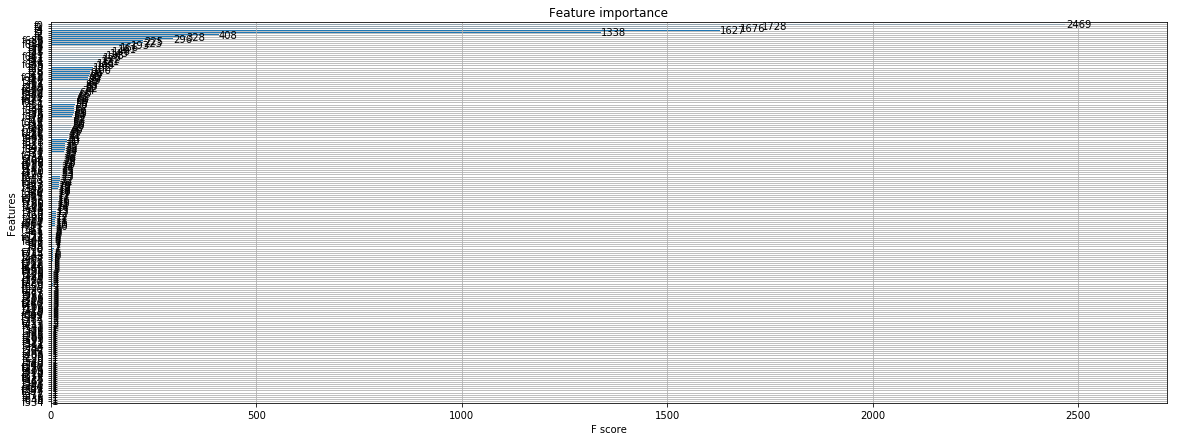

In [47]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20, 7))
plot_importance(model, ax=ax, height=0.4)

### Confusion Matrix

In [48]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(y_test, predictions), recall_score(y_test, predictions))

0.08693843594009984 0.831013916500994


In [49]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[195107   4390]
 [    85    418]]


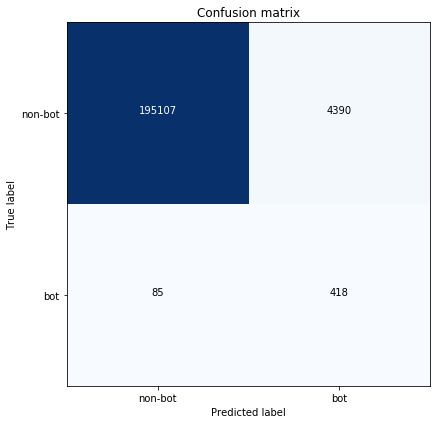

In [50]:
_ = plot_confusion_matrix(cm, classes=['non-bot','bot'])

### Scoring the model

In [51]:
r_xgb_clf.score(X_test, y_test)

0.960827310706307

In [52]:
printScoring(y_test, predictions)

Area under the precision-recall curve: 0.072672
Precision score: 0.086938
Recall score: 0.831014


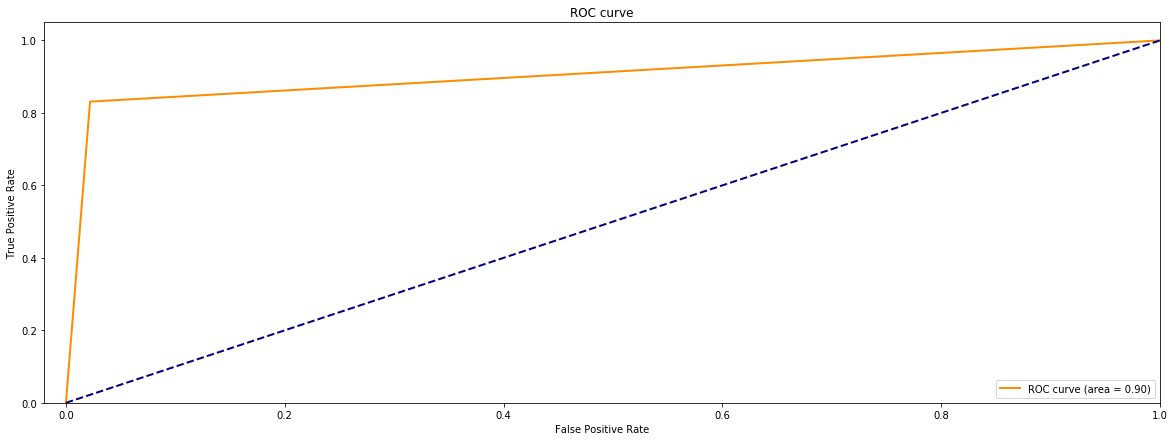

In [53]:
plotROC(y_test, predictions)

f1=0.157 auc=0.353 ap=0.355


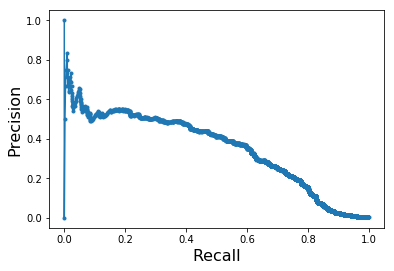

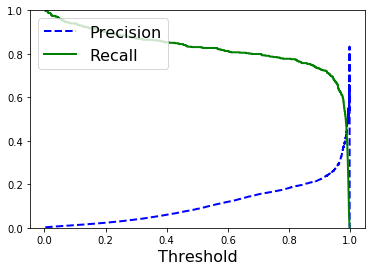

In [54]:
plotRecallCurve(
    ytest=y_test, 
    pred=predictions, 
    proba=predictions_proba[:, 1]
)

In [55]:
# Clean up
del model, predictions
gc.collect()

4609

## The second model using XGBClassifier

In [56]:
%%time
import xgboost as xgb

# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised

params = { 
    "n_estimators": 400,
    "tree_method":'gpu_hist',
    "predictor":'gpu_predictor',
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "scale_pos_weight": 9,
    "min_child_weight": 0,
    "reg_alpha": 4,
    "objective": 'binary:logistic'
}

clf_xgBoost = xgb.XGBClassifier(**params)

model = clf_xgBoost.fit(X_train, y_train)

CPU times: user 8.12 s, sys: 1.98 s, total: 10.1 s
Wall time: 10.1 s


### Predicting and saving the model

In [57]:
# model.save_model('models/cfl_xgboost_1.model')
# model = xgb.Booster({'nthread': 8})  # init model
# model.load_model('models/cfl_xgboost_1.model')  # load data

In [58]:
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)
recall_arr.append([predictions, predictions_proba[:, 1], 'Second Model'])

### Plotting the feature importance

When we now look at the feature importance of the Classifier vs the Regressor in the previous step, the `app`, `channel` and `ip`is now very strong features.

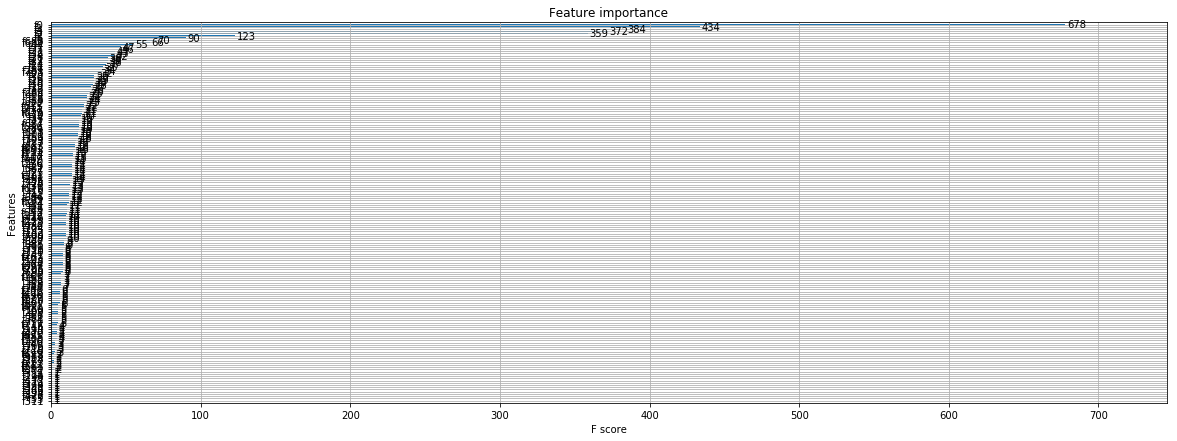

In [59]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20, 7))
plot_importance(model, ax=ax, height=0.4)

### Confusion Matrix

In [60]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(y_test, predictions), recall_score(y_test, predictions))

0.34868421052631576 0.6322067594433399


In [61]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[198903    594]
 [   185    318]]


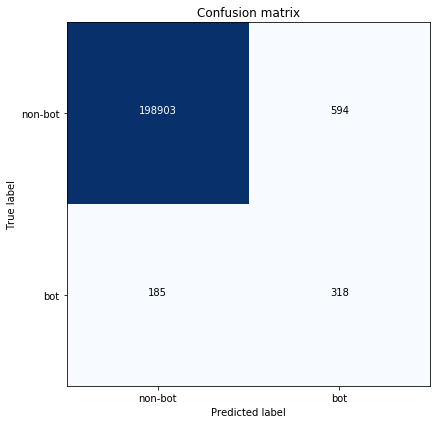

In [62]:
_ = plot_confusion_matrix(cm, classes=['non-bot','bot'])

### Scoring the model

In [63]:
printScoring(y_test, predictions)

Area under the precision-recall curve: 0.221366
Precision score: 0.348684
Recall score: 0.632207


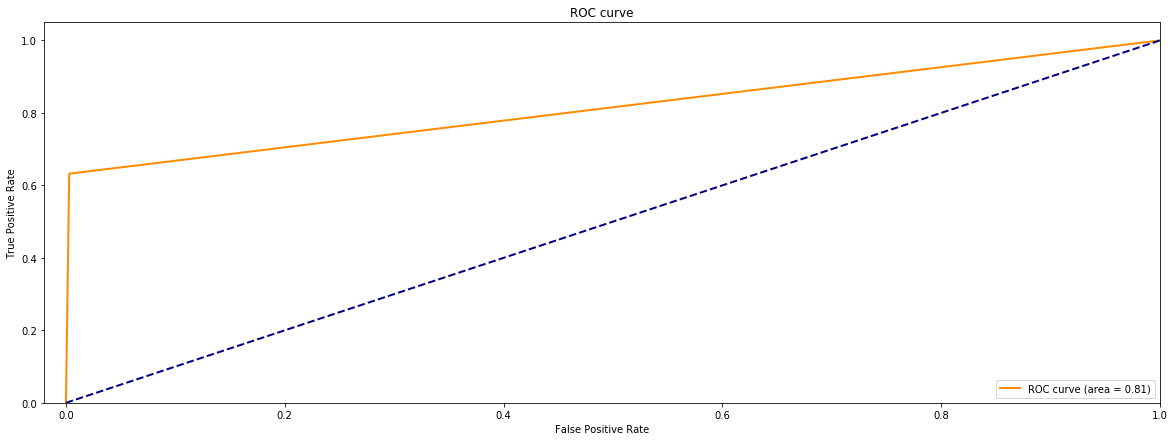

In [64]:
plotROC(y_test, predictions)

f1=0.449 auc=0.494 ap=0.495


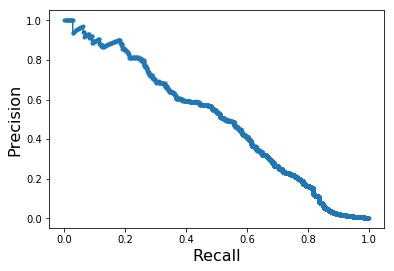

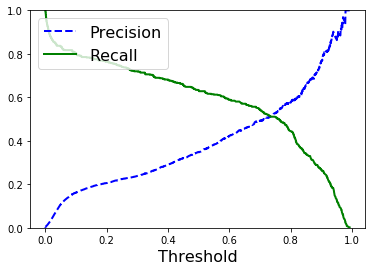

In [65]:
plotRecallCurve(
    ytest=y_test, 
    pred=predictions, 
    proba=predictions_proba[:, 1]
)

In [66]:
# Clean up
del model, predictions
gc.collect()

8444

## The third modell using XGBClassifier with Early Stopping

[Params borrowed from swethaboga](https://www.kaggle.com/swethaboga/xgboost-approx-tree-method)

In [67]:
params = {
    'eta': 0.3,
    'max_depth': 4, 
    'subsample': 0.8, 
    'colsample_bytree': 0.7, 
    'colsample_bylevel':0.7,
    'min_child_weight':0,
    'alpha':4,
    'objective': 'binary:logistic', 
    'scale_pos_weight':9,
    'eval_metric': 'auc', 
    'random_state': 42, 
    'silent': True,
    "tree_method":'gpu_hist',
    "predictor":'gpu_predictor',
}

watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]

model = xgb.train(params, xgb.DMatrix(X_train, y_train), 300, watchlist, maximize=True, early_stopping_rounds = 50, verbose_eval=10)

[0]	train-auc:0.678183	valid-auc:0.686311
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.904067	valid-auc:0.914591
[20]	train-auc:0.943664	valid-auc:0.943593
[30]	train-auc:0.958212	valid-auc:0.949409
[40]	train-auc:0.964539	valid-auc:0.951081
[50]	train-auc:0.970025	valid-auc:0.954171
[60]	train-auc:0.972127	valid-auc:0.956405
[70]	train-auc:0.97379	valid-auc:0.955784
[80]	train-auc:0.97626	valid-auc:0.957368
[90]	train-auc:0.978411	valid-auc:0.957244
[100]	train-auc:0.979583	valid-auc:0.958632
[110]	train-auc:0.980762	valid-auc:0.959065
[120]	train-auc:0.982026	valid-auc:0.959138
[130]	train-auc:0.982781	valid-auc:0.959136
[140]	train-auc:0.983989	valid-auc:0.959909
[150]	train-auc:0.98467	valid-auc:0.96043
[160]	train-auc:0.985635	valid-auc:0.960284
[170]	train-auc:0.986676	valid-auc:0.959847
[180]	train-auc:0.987433	valid-auc:0.95958
[190]	train-auc:0.988113	valid-auc:0.

### Predicting and saving the model

In [68]:
# model.save_model('models/sub_clf_xgboost_2.model')
# model = xgb.Booster({'nthread': 8})  # init model
# model.load_model('models/sub_clf_xgboost_2.model')  # load data

In [69]:
predictions_proba = model.predict(xgb.DMatrix(X_test))

predictions = np.array([pred > 0.5 if 1 else 0 for pred in predictions_proba])

recall_arr.append([predictions, predictions_proba, 'Third Model'])

### Plotting the feature importance

When we now compare the results with the other two models, the feature importance of the third model is very strong for the `channel` and the `app`. It's very difficult to come up with a conclution to what bots are targeting, but clearly there is a good combination of the application and the channel.

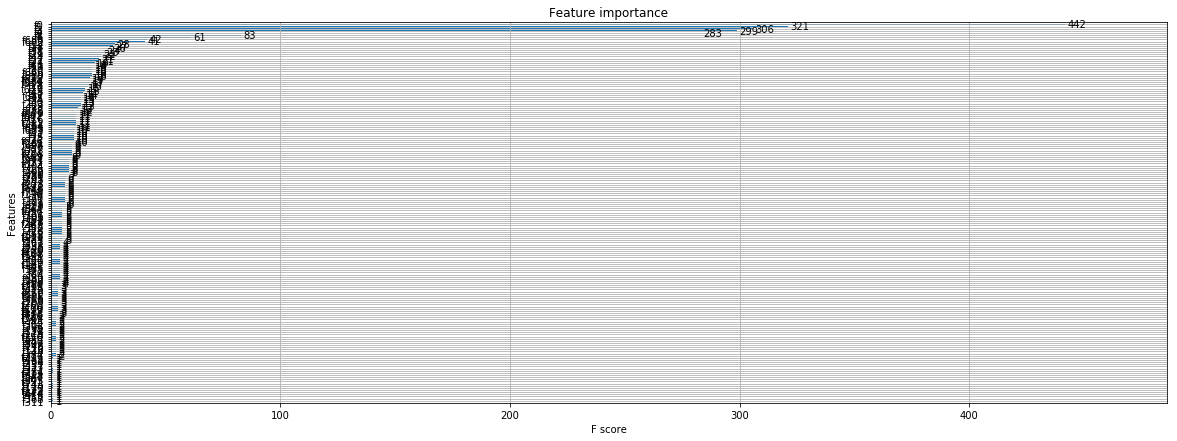

In [70]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20, 7))
plot_importance(model, ax=ax, height=0.4)

### Confusion Matrix

In [71]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(y_test, predictions), recall_score(y_test, predictions))

0.3603192702394527 0.6282306163021869


In [72]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[198936    561]
 [   187    316]]


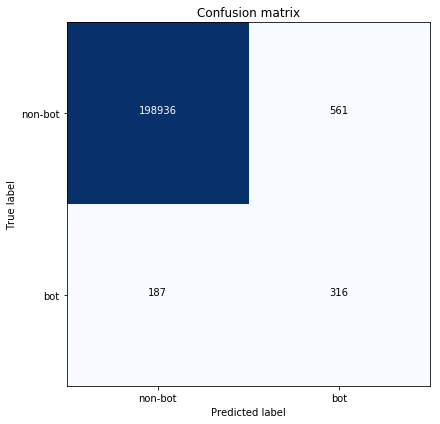

In [73]:
_ = plot_confusion_matrix(cm, classes=['non-bot','bot'])

### Scoring the model

In [74]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(y_test, predictions), recall_score(y_test, predictions))

0.3603192702394527 0.6282306163021869


In [75]:
model.get_score()

{'f693': 11,
 'f44': 22,
 'f669': 9,
 'f698': 6,
 'f311': 1,
 'f670': 12,
 'f717': 2,
 'f0': 442,
 'f2': 283,
 'f88': 4,
 'f308': 3,
 'f28': 17,
 'f38': 24,
 'f19': 18,
 'f1': 321,
 'f708': 9,
 'f690': 8,
 'f368': 1,
 'f281': 10,
 'f54': 11,
 'f688': 42,
 'f700': 4,
 'f147': 5,
 'f89': 5,
 'f55': 1,
 'f14': 16,
 'f78': 13,
 'f48': 15,
 'f679': 17,
 'f3': 306,
 'f4': 299,
 'f73': 6,
 'f5': 83,
 'f282': 11,
 'f682': 41,
 'f6': 61,
 'f685': 12,
 'f709': 8,
 'f111': 5,
 'f711': 11,
 'f689': 18,
 'f413': 1,
 'f855': 5,
 'f101': 6,
 'f686': 18,
 'f84': 2,
 'f117': 3,
 'f674': 1,
 'f684': 17,
 'f25': 8,
 'f112': 1,
 'f691': 9,
 'f704': 8,
 'f70': 6,
 'f123': 1,
 'f110': 1,
 'f59': 5,
 'f20': 18,
 'f57': 9,
 'f36': 9,
 'f9': 6,
 'f144': 2,
 'f718': 5,
 'f21': 19,
 'f12': 28,
 'f11': 23,
 'f677': 15,
 'f743': 1,
 'f176': 6,
 'f142': 4,
 'f151': 1,
 'f24': 21,
 'f7': 26,
 'f43': 1,
 'f27': 21,
 'f703': 6,
 'f687': 14,
 'f23': 18,
 'f676': 10,
 'f680': 4,
 'f46': 6,
 'f283': 13,
 'f118': 2,
 'f71

In [76]:
model.best_score

0.960971

In [77]:
printScoring(y_test, predictions)

Area under the precision-recall curve: 0.227299
Precision score: 0.360319
Recall score: 0.628231


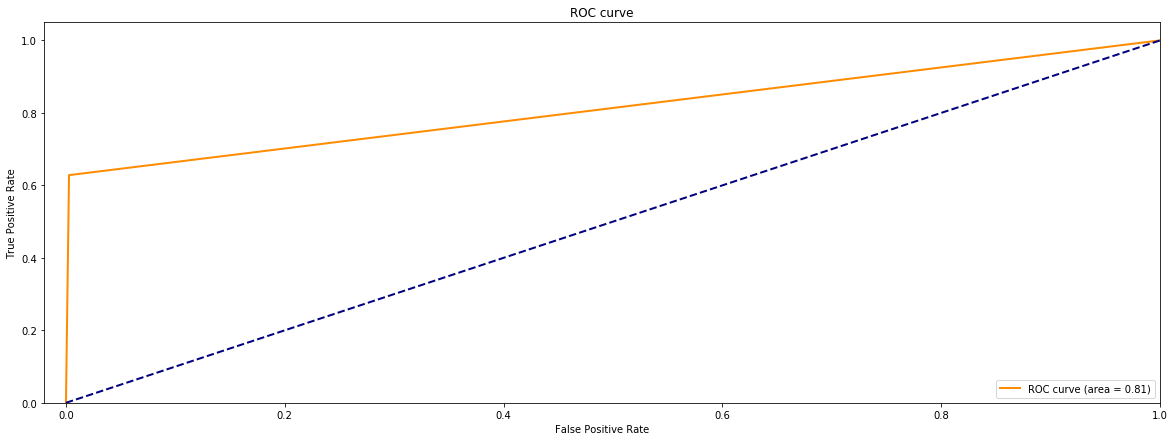

In [78]:
plotROC(y_test, predictions)

f1=0.458 auc=0.490 ap=0.491


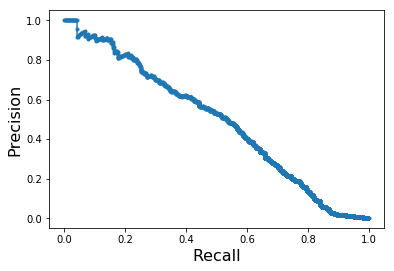

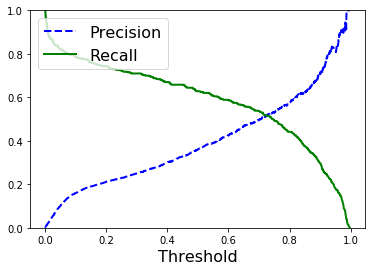

In [79]:
plotRecallCurve(
    ytest=y_test, 
    pred=predictions, 
    proba=predictions_proba
)

High Recall and Low Precision means many False Positives and few False Negative. That means the models marks many non-bots as bots.

f1=0.157 auc=0.353 ap=0.355
f1=0.449 auc=0.494 ap=0.495


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


f1=0.458 auc=0.490 ap=0.491


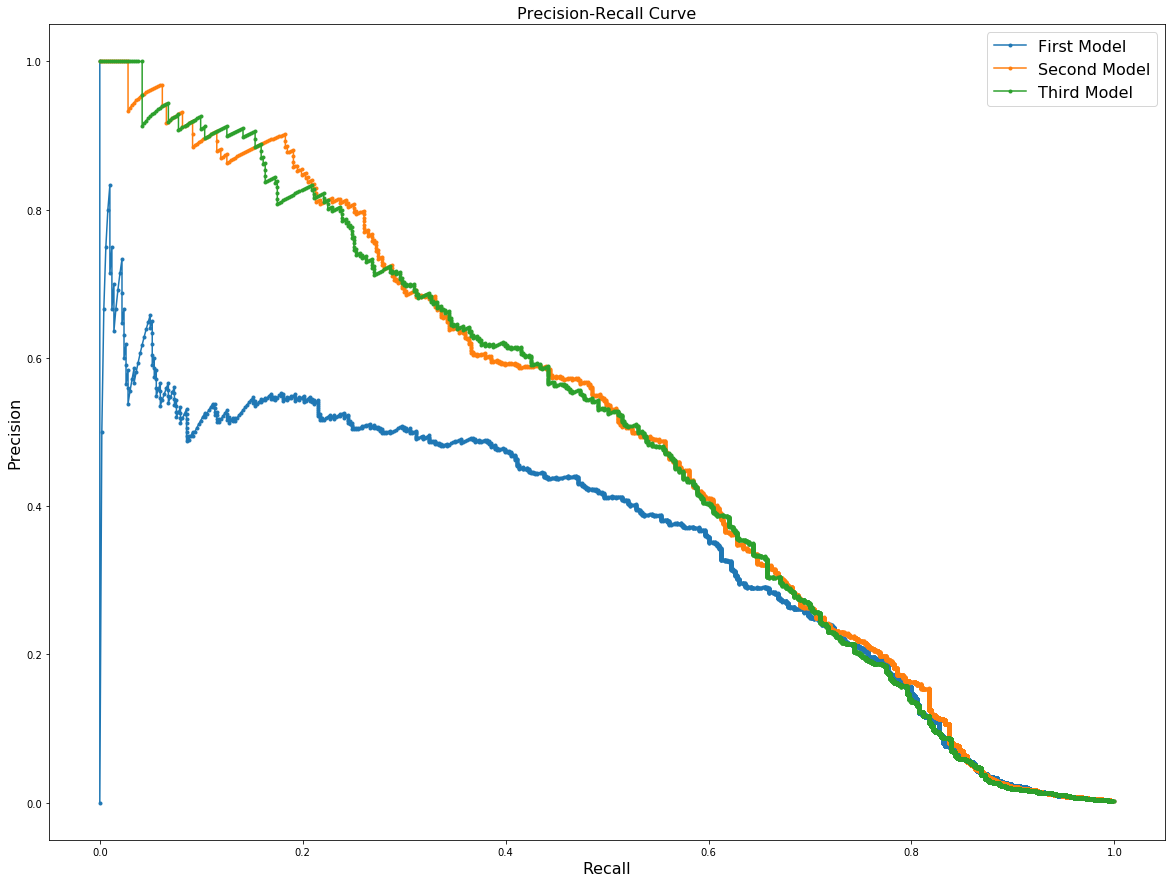

In [80]:
fig = plt.figure(figsize=(20, 15))

for i,data in enumerate(recall_arr):
    plt.subplot()
    plt.title("Precision-Recall Curve", fontsize=16)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    subRecallCurve(
        ytest=y_test,
        pred=data[0],
        proba=data[1],
        label=data[2]
    )
    plt.legend(fontsize=16)

In [81]:
del predictions
gc.collect()

8599

# Validating

Since the validation set to the test.csv is only available for Kaggle I'm only writing the predictions to a sub.csv and not doing any scores on the result.

In [82]:
validate = pd.read_csv('datasets/test.csv', dtype=dtypes, header=0)

In [83]:
sub = pd.DataFrame()
sub['click_id'] = validate['click_id']

In [84]:
validate = preprocessClicktime(validate)
validate = validate.drop(['click_id','click_time'], axis=1)
validate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 12 columns):
ip         uint32
app        uint16
device     uint16
os         uint16
channel    uint16
hour       uint8
minute     uint8
second     uint8
day        uint8
dow        uint8
doy        uint8
woy        uint8
dtypes: uint16(4), uint32(1), uint8(7)
memory usage: 340.5 MB


In [85]:
predictions = model.predict(xgb.DMatrix(validate))

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283', 'f284', 'f285', 'f286', 'f287', 'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296', 'f297', 'f298', 'f299', 'f300', 'f301', 'f302', 'f303', 'f304', 'f305', 'f306', 'f307', 'f308', 'f309', 'f310', 'f311', 'f312', 'f313', 'f314', 'f315', 'f316', 'f317', 'f318', 'f319', 'f320', 'f321', 'f322', 'f323', 'f324', 'f325', 'f326', 'f327', 'f328', 'f329', 'f330', 'f331', 'f332', 'f333', 'f334', 'f335', 'f336', 'f337', 'f338', 'f339', 'f340', 'f341', 'f342', 'f343', 'f344', 'f345', 'f346', 'f347', 'f348', 'f349', 'f350', 'f351', 'f352', 'f353', 'f354', 'f355', 'f356', 'f357', 'f358', 'f359', 'f360', 'f361', 'f362', 'f363', 'f364', 'f365', 'f366', 'f367', 'f368', 'f369', 'f370', 'f371', 'f372', 'f373', 'f374', 'f375', 'f376', 'f377', 'f378', 'f379', 'f380', 'f381', 'f382', 'f383', 'f384', 'f385', 'f386', 'f387', 'f388', 'f389', 'f390', 'f391', 'f392', 'f393', 'f394', 'f395', 'f396', 'f397', 'f398', 'f399', 'f400', 'f401', 'f402', 'f403', 'f404', 'f405', 'f406', 'f407', 'f408', 'f409', 'f410', 'f411', 'f412', 'f413', 'f414', 'f415', 'f416', 'f417', 'f418', 'f419', 'f420', 'f421', 'f422', 'f423', 'f424', 'f425', 'f426', 'f427', 'f428', 'f429', 'f430', 'f431', 'f432', 'f433', 'f434', 'f435', 'f436', 'f437', 'f438', 'f439', 'f440', 'f441', 'f442', 'f443', 'f444', 'f445', 'f446', 'f447', 'f448', 'f449', 'f450', 'f451', 'f452', 'f453', 'f454', 'f455', 'f456', 'f457', 'f458', 'f459', 'f460', 'f461', 'f462', 'f463', 'f464', 'f465', 'f466', 'f467', 'f468', 'f469', 'f470', 'f471', 'f472', 'f473', 'f474', 'f475', 'f476', 'f477', 'f478', 'f479', 'f480', 'f481', 'f482', 'f483', 'f484', 'f485', 'f486', 'f487', 'f488', 'f489', 'f490', 'f491', 'f492', 'f493', 'f494', 'f495', 'f496', 'f497', 'f498', 'f499', 'f500', 'f501', 'f502', 'f503', 'f504', 'f505', 'f506', 'f507', 'f508', 'f509', 'f510', 'f511', 'f512', 'f513', 'f514', 'f515', 'f516', 'f517', 'f518', 'f519', 'f520', 'f521', 'f522', 'f523', 'f524', 'f525', 'f526', 'f527', 'f528', 'f529', 'f530', 'f531', 'f532', 'f533', 'f534', 'f535', 'f536', 'f537', 'f538', 'f539', 'f540', 'f541', 'f542', 'f543', 'f544', 'f545', 'f546', 'f547', 'f548', 'f549', 'f550', 'f551', 'f552', 'f553', 'f554', 'f555', 'f556', 'f557', 'f558', 'f559', 'f560', 'f561', 'f562', 'f563', 'f564', 'f565', 'f566', 'f567', 'f568', 'f569', 'f570', 'f571', 'f572', 'f573', 'f574', 'f575', 'f576', 'f577', 'f578', 'f579', 'f580', 'f581', 'f582', 'f583', 'f584', 'f585', 'f586', 'f587', 'f588', 'f589', 'f590', 'f591', 'f592', 'f593', 'f594', 'f595', 'f596', 'f597', 'f598', 'f599', 'f600', 'f601', 'f602', 'f603', 'f604', 'f605', 'f606', 'f607', 'f608', 'f609', 'f610', 'f611', 'f612', 'f613', 'f614', 'f615', 'f616', 'f617', 'f618', 'f619', 'f620', 'f621', 'f622', 'f623', 'f624', 'f625', 'f626', 'f627', 'f628', 'f629', 'f630', 'f631', 'f632', 'f633', 'f634', 'f635', 'f636', 'f637', 'f638', 'f639', 'f640', 'f641', 'f642', 'f643', 'f644', 'f645', 'f646', 'f647', 'f648', 'f649', 'f650', 'f651', 'f652', 'f653', 'f654', 'f655', 'f656', 'f657', 'f658', 'f659', 'f660', 'f661', 'f662', 'f663', 'f664', 'f665', 'f666', 'f667', 'f668', 'f669', 'f670', 'f671', 'f672', 'f673', 'f674', 'f675', 'f676', 'f677', 'f678', 'f679', 'f680', 'f681', 'f682', 'f683', 'f684', 'f685', 'f686', 'f687', 'f688', 'f689', 'f690', 'f691', 'f692', 'f693', 'f694', 'f695', 'f696', 'f697', 'f698', 'f699', 'f700', 'f701', 'f702', 'f703', 'f704', 'f705', 'f706', 'f707', 'f708', 'f709', 'f710', 'f711', 'f712', 'f713', 'f714', 'f715', 'f716', 'f717', 'f718', 'f719', 'f720', 'f721', 'f722', 'f723', 'f724', 'f725', 'f726', 'f727', 'f728', 'f729', 'f730', 'f731', 'f732', 'f733', 'f734', 'f735', 'f736', 'f737', 'f738', 'f739', 'f740', 'f741', 'f742', 'f743', 'f744', 'f745', 'f746', 'f747', 'f748', 'f749', 'f750', 'f751', 'f752', 'f753', 'f754', 'f755', 'f756', 'f757', 'f758', 'f759', 'f760', 'f761', 'f762', 'f763', 'f764', 'f765', 'f766', 'f767', 'f768', 'f769', 'f770', 'f771', 'f772', 'f773', 'f774', 'f775', 'f776', 'f777', 'f778', 'f779', 'f780', 'f781', 'f782', 'f783', 'f784', 'f785', 'f786', 'f787', 'f788', 'f789', 'f790', 'f791', 'f792', 'f793', 'f794', 'f795', 'f796', 'f797', 'f798', 'f799', 'f800', 'f801', 'f802', 'f803', 'f804', 'f805', 'f806', 'f807', 'f808', 'f809', 'f810', 'f811', 'f812', 'f813', 'f814', 'f815', 'f816', 'f817', 'f818', 'f819', 'f820', 'f821', 'f822', 'f823', 'f824', 'f825', 'f826', 'f827', 'f828', 'f829', 'f830', 'f831', 'f832', 'f833', 'f834', 'f835', 'f836', 'f837', 'f838', 'f839', 'f840', 'f841', 'f842', 'f843', 'f844', 'f845', 'f846', 'f847', 'f848', 'f849', 'f850', 'f851', 'f852', 'f853', 'f854', 'f855', 'f856', 'f857', 'f858', 'f859', 'f860', 'f861'] ['ip', 'app', 'device', 'os', 'channel', 'hour', 'minute', 'second', 'day', 'dow', 'doy', 'woy']
expected f672, f442, f17, f751, f509, f585, f685, f175, f257, f386, f156, f694, f800, f856, f371, f512, f46, f348, f223, f774, f555, f289, f255, f118, f715, f96, f321, f23, f58, f368, f87, f782, f593, f823, f316, f479, f719, f400, f227, f123, f308, f596, f762, f770, f219, f482, f366, f484, f540, f159, f663, f651, f796, f189, f384, f282, f251, f630, f41, f145, f510, f470, f728, f514, f769, f83, f492, f723, f75, f499, f387, f689, f354, f546, f620, f767, f835, f92, f846, f76, f839, f162, f552, f209, f196, f451, f732, f210, f821, f14, f396, f549, f239, f697, f222, f758, f178, f695, f678, f429, f562, f181, f649, f91, f435, f64, f132, f140, f262, f481, f434, f783, f129, f652, f74, f640, f259, f772, f844, f842, f144, f197, f154, f458, f372, f743, f320, f714, f202, f847, f313, f498, f646, f843, f749, f745, f543, f777, f440, f801, f469, f270, f475, f551, f24, f90, f727, f615, f155, f245, f675, f707, f644, f62, f637, f781, f167, f436, f631, f233, f369, f497, f804, f522, f102, f190, f65, f78, f8, f201, f311, f363, f692, f454, f113, f665, f764, f188, f281, f785, f548, f194, f547, f276, f265, f455, f417, f660, f318, f495, f212, f439, f204, f826, f128, f3, f169, f283, f426, f450, f199, f409, f550, f848, f753, f736, f141, f746, f446, f565, f705, f29, f726, f854, f702, f389, f168, f231, f266, f731, f38, f268, f776, f476, f358, f182, f238, f696, f559, f327, f741, f829, f252, f137, f183, f566, f766, f342, f412, f592, f198, f30, f834, f328, f367, f225, f788, f416, f340, f230, f355, f473, f761, f619, f339, f406, f401, f688, f668, f34, f329, f682, f40, f513, f4, f356, f229, f158, f825, f381, f840, f343, f496, f33, f302, f713, f344, f735, f795, f323, f72, f478, f757, f420, f610, f19, f105, f50, f425, f667, f246, f179, f237, f55, f138, f584, f253, f602, f480, f634, f780, f515, f686, f191, f60, f331, f421, f122, f818, f277, f518, f805, f850, f408, f650, f690, f232, f560, f153, f471, f539, f414, f613, f623, f338, f109, f625, f347, f213, f95, f740, f725, f57, f151, f657, f11, f261, f742, f133, f85, f134, f200, f299, f765, f228, f345, f139, f605, f142, f466, f174, f608, f192, f119, f563, f117, f307, f670, f841, f22, f353, f679, f131, f803, f36, f263, f433, f37, f35, f407, f541, f335, f54, f517, f376, f234, f45, f789, f449, f173, f73, f166, f336, f485, f530, f849, f286, f557, f857, f588, f718, f814, f616, f48, f121, f763, f676, f177, f542, f374, f687, f810, f280, f448, f598, f146, f722, f294, f494, f709, f786, f306, f802, f63, f444, f833, f125, f346, f298, f504, f70, f594, f220, f385, f357, f326, f525, f185, f27, f636, f641, f43, f422, f292, f553, f699, f461, f647, f378, f379, f152, f107, f241, f532, f287, f734, f423, f438, f395, f459, f507, f528, f218, f570, f582, f332, f809, f242, f317, f671, f12, f572, f489, f639, f164, f700, f643, f703, f658, f296, f163, f193, f52, f680, f394, f632, f828, f127, f147, f310, f662, f673, f312, f664, f851, f493, f410, f445, f28, f403, f624, f506, f759, f273, f216, f160, f561, f830, f71, f418, f618, f571, f773, f574, f32, f6, f659, f836, f430, f419, f248, f531, f579, f359, f711, f491, f390, f822, f130, f337, f157, f568, f0, f291, f580, f581, f778, f683, f205, f462, f226, f824, f628, f750, f591, f837, f10, f556, f638, f792, f564, f622, f93, f752, f798, f468, f612, f206, f487, f617, f852, f648, f77, f361, f236, f626, f217, f136, f115, f606, f272, f483, f103, f441, f771, f428, f621, f799, f739, f180, f293, f304, f516, f831, f845, f717, f855, f832, f150, f295, f364, f629, f325, f775, f319, f284, f207, f214, f124, f391, f392, f411, f256, f314, f80, f126, f211, f61, f84, f721, f453, f405, f691, f267, f447, f779, f554, f244, f68, f274, f533, f108, f534, f597, f578, f519, f49, f397, f576, f172, f502, f56, f456, f655, f677, f601, f520, f31, f545, f712, f536, f1, f300, f813, f427, f53, f97, f334, f523, f349, f15, f432, f365, f2, f42, f558, f254, f208, f577, f501, f247, f297, f59, f609, f720, f51, f315, f161, f645, f586, f393, f431, f25, f176, f271, f452, f377, f573, f858, f67, f66, f278, f724, f415, f627, f859, f79, f595, f413, f590, f399, f642, f490, f47, f684, f808, f457, f94, f380, f100, f611, f258, f661, f21, f674, f708, f303, f474, f793, f488, f575, f279, f815, f186, f819, f111, f165, f203, f350, f603, f20, f505, f511, f853, f738, f171, f301, f305, f402, f730, f352, f388, f744, f460, f756, f149, f187, f404, f89, f633, f81, f39, f110, f135, f589, f569, f477, f538, f583, f784, f508, f812, f215, f362, f13, f370, f526, f240, f309, f44, f99, f811, f656, f98, f114, f269, f607, f443, f351, f463, f249, f333, f341, f88, f472, f710, f604, f748, f535, f861, f195, f500, f243, f148, f224, f16, f373, f524, f755, f860, f567, f170, f120, f82, f681, f790, f806, f221, f26, f807, f264, f666, f86, f235, f817, f375, f382, f653, f706, f729, f654, f787, f838, f104, f101, f733, f275, f465, f544, f383, f716, f250, f587, f424, f669, f360, f704, f467, f635, f820, f5, f106, f816, f797, f754, f69, f529, f330, f747, f537, f7, f486, f143, f464, f693, f322, f116, f737, f701, f698, f260, f760, f285, f290, f614, f398, f18, f184, f527, f9, f600, f768, f521, f288, f324, f794, f503, f437, f791, f827, f599, f112 in input data
training data did not have the following fields: channel, app, device, minute, second, os, doy, day, dow, hour, ip, woy

In [ ]:
sub['is_attributed'] = predictions

In [ ]:
sub.to_csv('sub.csv',index=False)